Using the dataset and ploting code from [Prediction Intervals for Gradient Boosting Regression](http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html)

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(1)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Prepare Dataset

In [2]:
def f(x):
    """The function to predict."""
    return x * np.sin(x)

#----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X = X.astype(np.float32)

# Observations
y = f(X).ravel()

dy = 1.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise
y = y.astype(np.float32)

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T
xx = xx.astype(np.float32)

X.shape, y.shape, xx.shape

((100, 1), (100,), (1000, 1))

## Build the Model

In [3]:
# Create network
class q_model:
    def __init__(self, 
                 sess, 
                 quantiles, 
                 in_shape=1, 
                 out_shape=1, 
                 batch_size=32,
                 dropout=0.5):
        
        self.sess = sess
        
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)
        
        self.in_shape = in_shape
        self.out_shape = out_shape
        self.batch_size = batch_size
        self.dropout = dropout
        
        self.outputs = []
        self.losses = []
        self.loss_history = []
        self.optim = tf.train.AdamOptimizer()
        
        self.build_model()
        
    def build_model(self, scope='q_model', reuse=tf.AUTO_REUSE): 
        with tf.variable_scope(scope, reuse=reuse) as scope:
            self.x = tf.placeholder(tf.float32, shape=(None, self.in_shape))
            self.y = tf.placeholder(tf.float32, shape=(None, self.out_shape))
            self.is_training = tf.placeholder(tf.bool)

            self.layer0 = tf.layers.dense(self.x, 
                                    units=64, 
                                    activation=tf.nn.relu)
            # self.layer0_dropped = tf.layers.dropout(tf.layers.batch_normalization(
            #     self.layer0), self.dropout, training=self.is_training)
            self.layer0_dropped = tf.layers.dropout(
                self.layer0, self.dropout, training=self.is_training)            
            self.layer1 = tf.layers.dense(self.layer0, 
                                    units=64, 
                                    activation=tf.nn.relu)
            # self.layer1_dropped = tf.layers.dropout(tf.layers.batch_normalization(
            #     self.layer1), self.dropout, training=self.is_training)
            self.layer1_dropped = tf.layers.dropout(
                self.layer1, self.dropout, training=self.is_training)
            # Create outputs and losses for all quantiles
            for i in range(self.num_quantiles):
                q = self.quantiles[i]
                
                # Get output layers 
                output = tf.layers.dense(self.layer1_dropped, 1, name="{}_q{}".format(i, int(q*100)))
                self.outputs.append(output)
                
                # Create losses
                error = tf.subtract(self.y, output)
                loss = tf.reduce_mean(tf.maximum(q*error, (q-1)*error), axis=-1)
                self.losses.append(loss)
                
            # Create combined loss with weight loss
            # self.combined_loss = tf.add(
            #     tf.reduce_mean(tf.add_n(self.losses)),
            #     1e-4 * tf.reduce_sum(tf.stack(
            #       [tf.nn.l2_loss(i) for i in tf.trainable_variables()]
            #     ))
            # )
            # Create combined loss
            self.combined_loss = tf.reduce_mean(tf.add_n(self.losses))
            self.train_step = self.optim.minimize(self.combined_loss)

    def fit(self, x, y, epochs=100):  
        for epoch in range(epochs):
            epoch_losses = []
            shuffle_idx = np.arange(x.shape[0])
            np.random.shuffle(shuffle_idx)
            x = x[shuffle_idx]
            y = y[shuffle_idx]
            for idx in range(0, x.shape[0], self.batch_size):
                batch_x = x[idx : min(idx + self.batch_size, x.shape[0]),:]
                batch_y = y[idx : min(idx + self.batch_size, y.shape[0]),:]

                feed_dict = {
                    self.x: batch_x,
                    self.y: batch_y,
                    self.is_training: True
                }
                
                _, c_loss = self.sess.run([self.train_step, self.combined_loss], feed_dict)
                epoch_losses.append(c_loss)
                
            epoch_loss =  np.mean(epoch_losses)
            self.loss_history.append(epoch_loss)
            if epoch % 500 == 0:
                print("Epoch {}: {}".format(epoch, epoch_loss))
            
    def predict(self, x, is_training=False):   
        # Run model to get outputs
        feed_dict = {self.x: x, self.is_training: is_training}
        predictions = sess.run(self.outputs, feed_dict)
        
        return [x[:, 0] for x in predictions]

In [4]:
# Initialize session
sess = tf.Session()

# Instantiate model
quantiles = [.05, .5, .95]
model = q_model(sess, quantiles, batch_size=10, dropout=0.25)

# Initialize all variables
init_op = tf.global_variables_initializer()
sess.run(init_op)

## Train the Model

In [5]:
# Run training
epochs = 10000
model.fit(X, y[:, np.newaxis], epochs)

Epoch 0: 4.687920570373535
Epoch 500: 2.301460027694702
Epoch 1000: 1.9910444021224976
Epoch 1500: 1.8227161169052124
Epoch 2000: 1.510740876197815
Epoch 2500: 1.4583473205566406
Epoch 3000: 1.3682154417037964
Epoch 3500: 1.251922607421875
Epoch 4000: 1.2527492046356201
Epoch 4500: 1.2576420307159424
Epoch 5000: 1.2368781566619873
Epoch 5500: 1.3565553426742554
Epoch 6000: 1.1915109157562256
Epoch 6500: 1.2412769794464111
Epoch 7000: 1.284339189529419
Epoch 7500: 1.1990386247634888
Epoch 8000: 1.2564207315444946
Epoch 8500: 1.2143256664276123
Epoch 9000: 1.1790869235992432
Epoch 9500: 1.2402336597442627


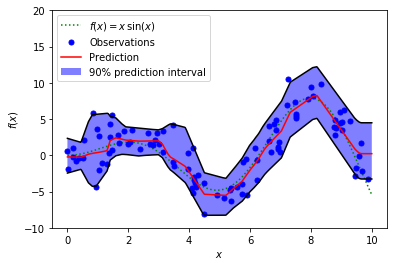

In [6]:
# Make the prediction on the meshed x-axis
y_lower, y_pred, y_upper = model.predict(xx)

# Plot the function, the prediction and the 90% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(xx, f(xx), 'g:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
plt.plot(xx, y_pred, 'r-', label=u'Prediction')
plt.plot(xx, y_upper, 'k-')
plt.plot(xx, y_lower, 'k-')
plt.fill(np.concatenate([xx, xx[::-1]]),
         np.concatenate([y_upper, y_lower[::-1]]),
         alpha=.5, fc='b', ec='None', label='90% prediction interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')
plt.show()

In [7]:
predictions = model.predict(X)
np.mean(predictions[0]), np.mean(predictions[1]), np.mean(predictions[2])

(-2.0827007, 0.81326693, 4.3527694)

In [8]:
in_the_range = np.sum((y >= predictions[0]) & (y <= predictions[2]))
print("Percentage in the range (expecting 90%):", in_the_range / len(y) * 100)

Percentage in the range (expecting 90%): 95.0


In [9]:
out_of_the_range = np.sum((y < predictions[0]) | (y > predictions[2]))
print("Percentage out of the range (expecting 10%):", out_of_the_range / len(y)  * 100)

Percentage out of the range (expecting 10%): 5.0


In [10]:
predictions[0].shape

(100,)

## MC Prediction

In [11]:
K = 5000
tmp = np.zeros((K, xx.shape[0])).astype("float32")
for k in range(K):
    _, preds, _ = model.predict(xx, is_training=True)
    tmp[k] = preds
y_lower, y_pred, y_upper = np.percentile(tmp, (5, 50, 95), axis=0)    

In [12]:
y_lower[1], y_pred[1], y_upper[1]

(-0.3988814353942871, -0.20499774813652039, 0.05016273260116577)

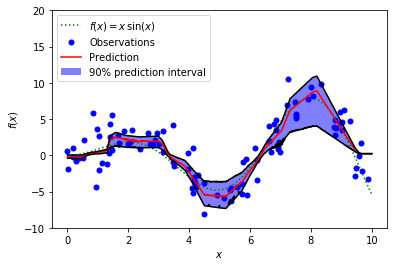

In [13]:
# Plot the function, the prediction and the 90% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(xx, f(xx), 'g:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
plt.plot(xx, y_pred, 'r-', label=u'Prediction')
plt.plot(xx, y_upper, 'k-')
plt.plot(xx, y_lower, 'k-')
plt.fill(np.concatenate([xx, xx[::-1]]),
         np.concatenate([y_upper, y_lower[::-1]]),
         alpha=.5, fc='b', ec='None', label='90% prediction interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')
plt.show()

In [14]:
tmp = np.zeros((K, X.shape[0])).astype("float32")
for k in range(K):
    _, preds, _ = model.predict(X, is_training=True)
    tmp[k] = preds
predictions = np.percentile(tmp, (5, 50, 95), axis=0) 
np.mean(predictions[0]), np.mean(predictions[1]), np.mean(predictions[2])

(-0.3448927809819579, 0.8716518473625183, 1.738658199220896)

In [15]:
in_the_range = np.sum((y >= predictions[0]) & (y <= predictions[2]))
print("Percentage in the range (expecting 90%):", in_the_range / len(y) * 100)

Percentage in the range (expecting 90%): 43.0


In [16]:
out_of_the_range = np.sum((y < predictions[0]) | (y > predictions[2]))
print("Percentage out of the range (expecting 10%):", out_of_the_range / len(y)  * 100)

Percentage out of the range (expecting 10%): 56.99999999999999


In [17]:
truncate = (X[:, 0] >= 4) & (X[:, 0] <= 6)
in_the_range = np.sum((y[truncate] >= predictions[0][truncate]) & (y[truncate] <= predictions[2][truncate]))
print("Percentage in the range (expecting 90%):", in_the_range / len(y[truncate]) * 100)

Percentage in the range (expecting 90%): 61.904761904761905
